In [10]:
import numpy as np
import nashpy as nash
import random
import matplotlib.pyplot as plt

In [11]:
class Player:
    def __init__(self, isDove = None, id = -1):
        self.isDove = isDove
        self.id = id
        self.replenishment = 0
        self.x = 0
        self.y = 0


In [12]:
class Simulation:
    def __init__(self, N = 100, N_doves = 50, N_hawks = 50, env_size = 50, food_density = 0.25, payoff_matrix = None):
        self.N = N
        self.N_doves = N_doves
        self.N_hawks = N_hawks
        self.doves = []
        self.hawks = []
        self.food_density = food_density
        self.env_size = env_size
        self.environment = np.full((env_size, env_size) , 0)
        self.dove_loc = np.full((env_size, env_size) , None)
        self.hawk_loc = np.full((env_size, env_size) , None)
        self.payoff_matrix = payoff_matrix

    def spawnPlayers(self):
        id = 1
        for i in range(self.N_doves):
            dove = Player(True, id)
            self.doves.append(dove)
            id+=1

        for i in range(self.N_hawks):
            hawk = Player(False, id)
            self.hawks.append(hawk)
            id+=1

    def resetPlayerPositions(self):
        edges = {
            'top': [[0, i] for i in range(self.env_size)],
            'bottom': [[self.env_size - 1, i] for i in range(self.env_size)],
            'left': [[i, 0] for i in range(self.env_size)],
            'right': [[i, self.env_size - 1] for i in range(self.env_size)]
        }

        self.dove_loc = np.full((self.env_size, self.env_size) , None)
        self.hawk_loc = np.full((self.env_size, self.env_size) , None)

        for dove in self.doves:
            selected_edge = np.random.choice(list(edges.keys()))
            selected_point = edges[selected_edge][np.random.randint(len(edges[selected_edge]))]
            dove.x = selected_point[0]
            dove.y = selected_point[1]
            self.dove_loc[dove.x, dove.y] = dove

        for hawk in self.hawks:
            selected_edge = np.random.choice(list(edges.keys()))
            selected_point = edges[selected_edge][np.random.randint(len(edges[selected_edge]))]
            hawk.x = selected_point[0]
            hawk.y = selected_point[1]
            self.hawk_loc[hawk.x, hawk.y] = hawk
                
    def simulateMatch(self, p1, p2):
        if(not p1 and not p2):
            return
        elif(p1 and not p2):
            p1.replenishment+=2
        elif(p2 and not p1):
            p2.replenishment+=2
        elif(p1.isDove and p2.isDove):
            #both players live to see the next day nothing happens
            p1.replenishment+=self.payoff_matrix[0,0,0]
            p2.replenishment+=self.payoff_matrix[0,0,1]
        elif(p1.isDove and not p2.isDove):
            #p2 steals the food, from p1. p2 has a 50% chance of reproduction while p1 has a 50% chance of survival
            p1.replenishment += self.payoff_matrix[0,1,0]
            p2.replenishment += self.payoff_matrix[0,1,1]
        elif(not p1.isDove and p2.isDove):
            #p1 steals the food, from p2. p1 has a 50% chance of reproduction while p2 has a 50% chance of survival
            p1.replenishment += self.payoff_matrix[1,0,0]
            p2.replenishment += self.payoff_matrix[1,0,1]
        elif(not p1.isDove and not p2.isDove):
            p1.replenishment += self.payoff_matrix[1,1,0]
            p2.replenishment += self.payoff_matrix[1,1,1]

    def runSimulation(self, ticks, daily_moves):

        ticker = [i+1 for i in range(ticks)]
        number_of_players = []
        number_of_hawks = []
        number_of_doves = []

        for i in range(ticks):
            # at the start of each day spawn food particles in random squares
            total_squares = self.env_size**2
            num_food_squares = int(total_squares*self.food_density)
            food_indices = np.random.choice(total_squares, num_food_squares, replace=False)
            for index in food_indices:
                row, col = divmod(index, self.env_size)
                self.environment[row, col] = 1

            # allow each player to make 25 random moves
            for i in range(daily_moves):
                for player in self.doves:
                    self.dove_loc[player.x, player.y] = None
                    player.x += random.choice([1,-1,0])
                    player.y += random.choice([1,-1,0])
                    if(player.x >= self.env_size):
                        player.x-=1
                    if(player.y >= self.env_size):
                        player.y-=1
                    if(player.x < 0):
                        player.x+=1
                    if(player.y < 0):
                        player.y+=1
                    self.dove_loc[player.x, player.y] = player
                for player in self.hawks:
                    self.hawk_loc[player.x, player.y] = None
                    player.x += random.choice([1,-1,0])
                    player.y += random.choice([1,-1,0])
                    if(player.x >= self.env_size):
                        player.x-=1
                    if(player.y >= self.env_size):
                        player.y-=1
                    if(player.x < 0):
                        player.x+=1
                    if(player.y < 0):
                        player.y+=1
                    self.hawk_loc[player.x, player.y] = player

                for i in range(self.env_size):
                    for j in range(self.env_size):
                        if(self.environment[i,j] == 1):
                            self.simulateMatch(self.dove_loc[i,j], self.hawk_loc[i,j]) # this will update the replenishment scores for each player
                            self.environment[i,j] = 0 #removes the food particles since it is consumed


            # at the end of the day, loops through all the players in the lists and decides their fate based on their replenishment scores
            new_doves = []
            for dove in self.doves:
                if(dove.replenishment < 1):
                    if(random.randint(1,100) < 100*(1 - dove.replenishment)):
                        self.dove_loc[dove.x, dove.y] = None
                        self.doves.remove(dove)
                        self.N_doves -= 1
                        self.N -= 1
                        del dove
                    else:
                        # reset this replenishment at the end of the day
                        dove.replenishment = 0
                        # can chose to reset the position of the dove - doesn't really matter though
                elif(dove.replenishment < 2):
                    if(random.randint(1,100) > 100*(2 - dove.replenishment)):
                        # here we reproduce
                        new_doves.append(Player(True, self.N+1))
                        self.N+=1
                        self.N_doves+=1
                    else:
                        # reset this replenishment at the end of the day
                        dove.replenishment = 0
                        # can chose to reset the position of the dove - doesn't really matter though
                else:
                    # here we reproduce
                    new_doves.append(Player(True, self.N+1))
                    self.N+=1
                    self.N_doves+=1

            self.doves.extend(new_doves)

            new_hawks = []
            for hawk in self.hawks:
                if(hawk.replenishment < 1):
                    if(random.randint(1,100) < 100*(1 - hawk.replenishment)):
                        self.hawk_loc[hawk.x, hawk.y] = None
                        self.hawks.remove(hawk)
                        self.N_hawks -= 1
                        self.N-=1
                        del hawk
                    else:
                        # reset this replenishment at the end of the day
                        hawk.replenishment = 0
                        # can chose to reset the position of the dove - doesn't really matter though
                elif(hawk.replenishment < 2):
                    if(random.randint(1,100) > 100*(2 - hawk.replenishment)):
                        # here we reproduce
                        new_hawks.append(Player(True, self.N+1))
                        self.N+=1
                        self.N_hawks+=1
                    else:
                        # reset this replenishment at the end of the day
                        hawk.replenishment = 0
                        # can chose to reset the position of the dove - doesn't really matter though
                else:
                    new_hawks.append(Player(True, self.N+1))
                    self.N+=1
                    self.N_hawks+=1
                    
            self.hawks.extend(new_hawks)
            number_of_doves.append(self.N_doves)
            number_of_hawks.append(self.N_hawks)
            number_of_players.append(self.N)

            # reset the player positions at the end of the day
            self.resetPlayerPositions()

        # Plotting the metrics
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.plot(ticker, number_of_players, marker='o')
        plt.xlabel('Ticker')
        plt.ylabel('Number of Players')
        plt.title('Number of Players Over Ticks')

        plt.subplot(1, 3, 2)
        plt.plot(ticker, number_of_hawks, marker='o', color='r')
        plt.xlabel('Ticker')
        plt.ylabel('Number of Hawks')
        plt.title('Number of Hawks Over Ticks')

        plt.subplot(1, 3, 3)
        plt.plot(ticker, number_of_doves, marker='o', color='g')
        plt.xlabel('Ticker')
        plt.ylabel('Number of Doves')
        plt.title('Number of Doves Over Ticks')

        plt.tight_layout()
        plt.show()

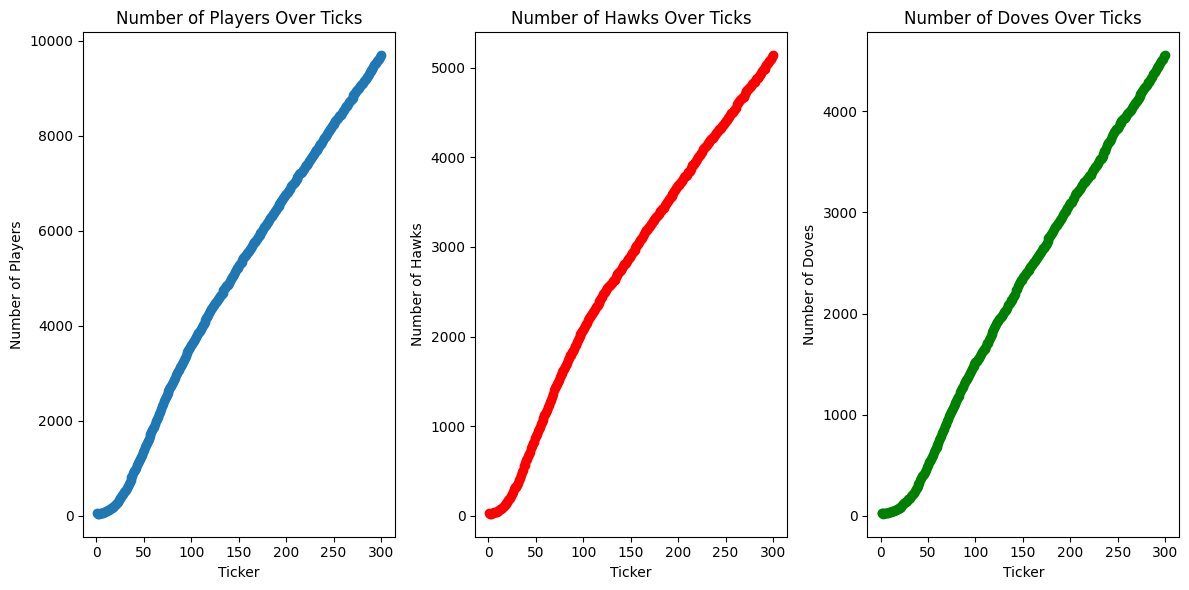

Total number of players is : 9691
Total number of hawks is : 5138
Total number of doves is : 4553


In [16]:
payoff = np.array([[[1,1], [1/2,3/2]],
                  [[3/2,1/2], [1/4,1/4]]])
s = Simulation(100,50,50, 50, 0.1, payoff)
s.spawnPlayers()
s.resetPlayerPositions()
s.runSimulation(300, 10)

print(f"Total number of players is : {s.N}")
print(f"Total number of hawks is : {s.N_hawks}")
print(f"Total number of doves is : {s.N_doves}")